## Import Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from tqdm import tqdm
from graphviz import Graph

from prim import getTree
from prim_algo import prims # implementation of prim's algo used in this code
from JVHW.est_MI import est_MI_JVHW, est_MI_MLE
from JVHW.test_entro import entropy_true, validate_dist, randsmpl

## Load the dataset

In [2]:
df = pd.read_csv('alarm10K.csv')
df.head()

,HISTORY,CVP,PCWP,HYPOVOLEMIA,LVEDVOLUME,LVFAILURE,STROKEVOLUME,ERRLOWOUTPUT,HRBP,HREKG,...,MINVOLSET,VENTMACH,VENTTUBE,VENTLUNG,VENTALV,ARTCO2,CATECHOL,HR,CO,BP
0,False,NORMAL,NORMAL,False,NORMAL,False,NORMAL,False,HIGH,HIGH,...,NORMAL,ZERO,ZERO,LOW,HIGH,LOW,HIGH,HIGH,HIGH,HIGH
1,False,NORMAL,NORMAL,False,NORMAL,False,LOW,False,HIGH,HIGH,...,HIGH,HIGH,ZERO,ZERO,ZERO,HIGH,HIGH,HIGH,LOW,LOW
2,False,NORMAL,NORMAL,False,NORMAL,False,NORMAL,False,NORMAL,HIGH,...,HIGH,HIGH,HIGH,LOW,HIGH,LOW,NORMAL,LOW,LOW,NORMAL
3,False,NORMAL,NORMAL,False,NORMAL,False,NORMAL,False,HIGH,HIGH,...,NORMAL,NORMAL,LOW,ZERO,ZERO,HIGH,HIGH,HIGH,HIGH,HIGH
4,False,NORMAL,NORMAL,False,NORMAL,False,NORMAL,False,HIGH,HIGH,...,NORMAL,NORMAL,LOW,ZERO,LOW,HIGH,HIGH,HIGH,HIGH,HIGH


### Check for NaN and Null values

In [3]:
df.isnull().values.any()

False

## Get the Joint probability distributions $P(x,y)$

In [4]:
# get joint distributions P(x,y)
probs = []
for i in tqdm(range(len(df.columns))):
    for j in range(len(df.columns)):
        if i < j:
            a = (df.groupby([df.columns[i],df.columns[j]]).size().unstack(fill_value=0).stack())/len(df)
            i_shape = len(df[df.columns[i]].unique()) # number of different unique variables
            j_shape = len(df[df.columns[j]].unique()) # number of different unique variables
            a = (np.array(a)).reshape((i_shape,j_shape))
            probs.append([i,j,a])


100%|██████████| 37/37 [00:03<00:00, 10.23it/s]


## Plug-In Estimator for Mutual Information

In [5]:
def getMutualInfo(pxy):
    assert np.round(np.sum(pxy)) == 1
    px = np.sum(pxy,axis=1)
    py = np.sum(pxy,axis=0)
    I = 0
    for i in range(pxy.shape[0]):
        for j in range(pxy.shape[1]):
            if pxy[i,j]:
                I += pxy[i,j]*math.log(pxy[i,j]/(px[i]*py[j]),2)
    return I


## Get the mutual information between all possible variables

In [6]:
mutualInfoMatrix = []

for p in probs:
    i,j,pxy = p
    I = getMutualInfo(pxy)
    mutualInfoMatrix.append([i,j,-I])

## Use Prim's Algorithm to get Minimum Spanning Tree

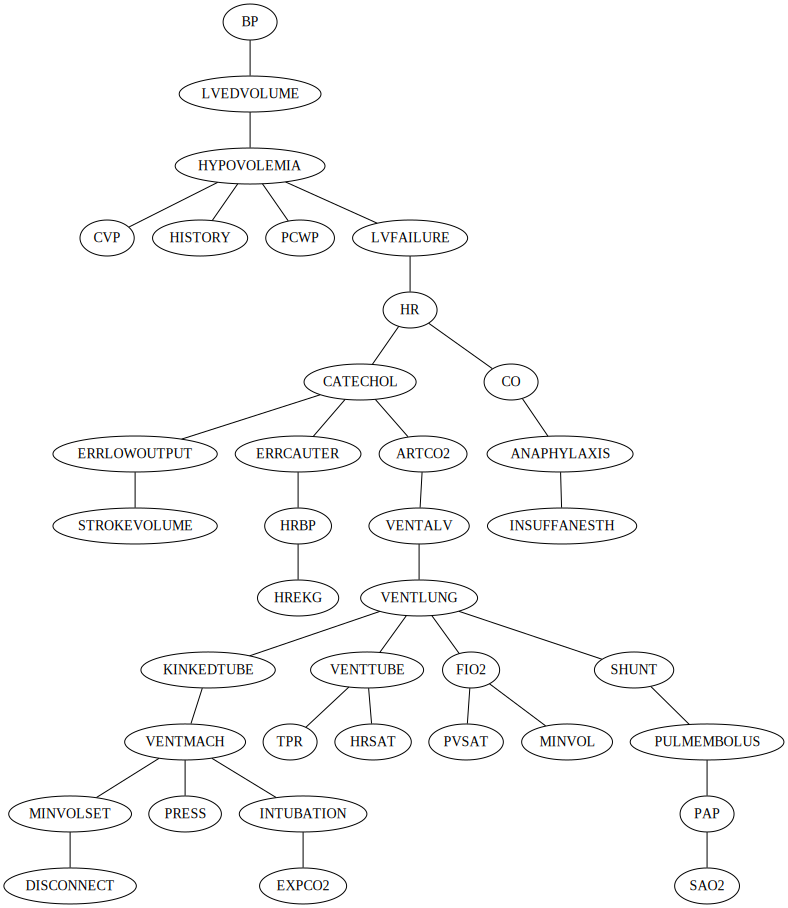

In [7]:
g=prims(len(df.columns),mutualInfoMatrix)
dot = Graph()
hist=[]
weights = []
for i in range(len(g)):
    src,dest,weight = g[i]
    if not [dest,src] in hist:
#         print(-weight)
        dot.edge(df.columns[src-1],df.columns[dest-1])
        hist.append([src,dest])
        weights.append([weight])
dot

In [8]:
# mst = getTree(37,np.array(mutualInfoMatrix),1,0)
# dot = Graph()
# graph = mst.getGraph()
# hist = []
# for i in range(len(graph)):
#     src,dest,weight = graph[i]
#     print(weight)
#     if not [dest,src] in hist:
#         dot.edge(df.columns[src-1],df.columns[dest-1])
#         hist.append([src,dest])

# dot

# JVHW Estimator for Mutual Information

In [9]:
def MI_true(pxy):
    """computes mutual information I(X;Y) given the joint distribution

    Input:
    ----- pxy: Sx-by-Sy matrix capturing the joint probability masses of the
               the bivariate RVs (X,Y), where Sx and Sy are the support size
               of X and Y, respectively. The (i,j)-th entry of pxy denotes
               the joint probability Pr(X = i,Y = j).

    Output:
    ----- MI: the mutual information I(X;Y), which is a scaler.
    """
    flat_pxy = pxy.flatten()
    validate_dist(flat_pxy)

    px = pxy.sum(axis=0)
    py = pxy.sum(axis=1)

    return entropy_true(px) + entropy_true(py) - entropy_true(flat_pxy)



## Get the mutual information between all possible variables

In [10]:
mutualInfoMatrixJVHW = []

for p in probs:
    i,j,pxy = p
    I = MI_true(pxy)
    mutualInfoMatrixJVHW.append([i,j,-I])

## Use Prim's Algorithm to get Minimum Spanning Tree

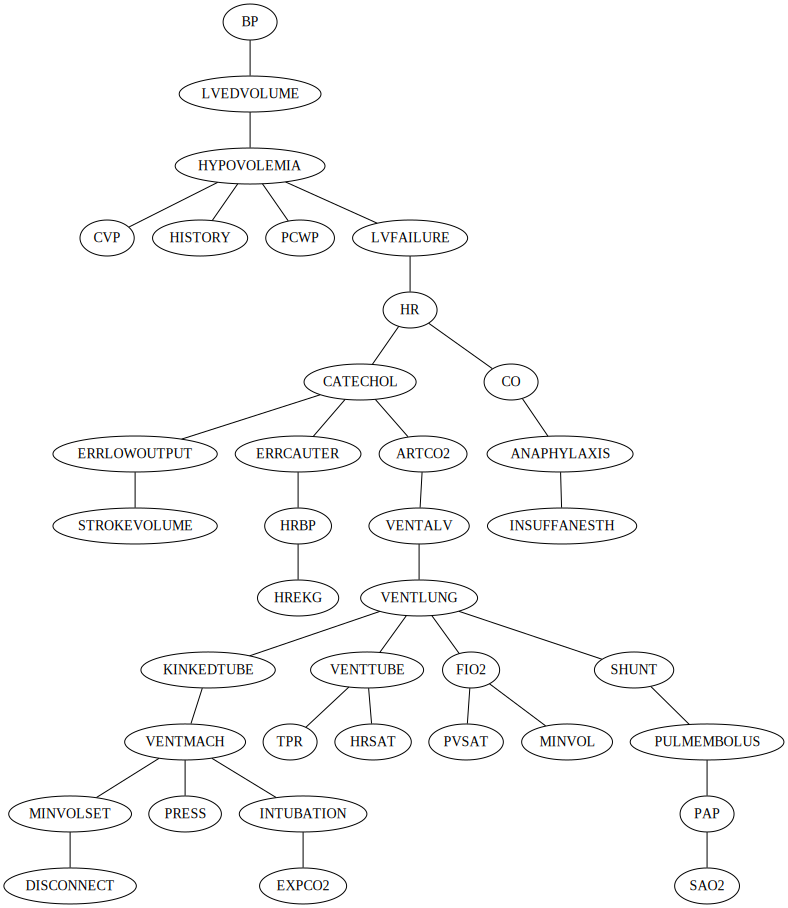

In [11]:
g=prims(len(df.columns),mutualInfoMatrixJVHW)
dotJVHW = Graph()
hist=[]
weightsJVHW = []
for i in range(len(g)):
    src,dest,weight = g[i]
    if not [dest,src] in hist:
#         print(-weight)
        dotJVHW.edge(df.columns[src-1],df.columns[dest-1])
        hist.append([src,dest])
        weightsJVHW.append(weight)
dotJVHW

In [12]:
# mst = getTree(37,np.array(mutualInfoMatrixJVHW),1,0)
# dotJVHW = Graph()
# graph = mst.getGraph()
# hist = []
# for i in range(len(graph)):
#     src,dest,weight = graph[i]
#     if not [dest,src] in hist:
#         dotJVHW.edge(df.columns[src-1],df.columns[dest-1])
#         hist.append([src,dest])
    
# # dot.edge(str(0),str(1))
# dotJVHW

## Save the Graphs as pdf

In [13]:
if not os.path.exists('./GraphOutputs'):
    os.makedirs('./GraphOutputs')
dot.render('GraphOutputs/plugin.gv',view=True)
dotJVHW.render('GraphOutputs/JVHW.gv',view=True)

'GraphOutputs/JVHW.gv.pdf'

## Extra Observations

In [14]:
num_variables = len(df.columns)
MI_matrix = np.zeros((num_variables,num_variables))
MI_JVHW_matrix = np.zeros((num_variables,num_variables))
for p in probs:
    i,j,pxy = p
    I_plug = getMutualInfo(pxy) # plug in
    I_JVHW = MI_true(pxy) # JVHW
    MI_matrix[i,j] = I_plug
    MI_JVHW_matrix[i,j] = I_JVHW

## Mean Square Error between the Mutual Information matrices obtained from Plugin Estimator and JVHW estimator

The L1 norm as well as the L2 norm between the mutual information matrices obtained from the plugin estimator as well as the JVHW estimator is quite small. Which implies that both are almost equal.

In [15]:
print(np.linalg.norm(MI_JVHW_matrix-MI_matrix,2))
print(np.linalg.norm(MI_JVHW_matrix-MI_matrix,1))

4.283526717899884e-15
1.7096350377054925e-14


## The weights between the nodes in both the graphs obtained
The weights between the nodes in the tree obtained are also quite similar. All the values of the weights between the nodes are comparable to each other and hence there is no need of removal of nodes from the graph for weights being very small.

The reason for removal of nodes is that we if the weights between a variable is very small then practically it is independent of all other variables and hence does not belong to any tree. Although, there is no requirement of removal of nodes in this problem.

In [16]:
weights = -np.array(weights).reshape((len(weights),1))
weightsJVHW = -np.array(weightsJVHW).reshape((len(weightsJVHW),1))
pd.DataFrame(np.concatenate((weights,weightsJVHW),1),columns=['Plugin','JVHW'])

,Plugin,JVHW
0,0.203017,0.203017
1,0.185770,0.185770
2,0.883967,0.883967
3,0.650134,0.650134
4,0.410676,0.410676
5,0.155506,0.155506
6,0.451881,0.451881
7,0.348432,0.348432
8,0.572157,0.572157
9,0.518383,0.518383
